# Multi-armed Bandits
An implementation of the $k$-armed bandit problem with greedy and $\epsilon$-greedy action selection methods as described in Chapter 2 of _Reinforcement Learning: An Introduction, 2nd Edition (2018)_ by Richard S. Sutton and Andrew G. Barto.

The "10-armed testbed" described in the book is reproduced for an ensemble of bandits and the average performance is plot for a number of values of $\epsilon$. 

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp

%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
class KArmedBandit:
    """
    Class implementing a k-armed bandit.
    
    For each of the k actions, the expected action is initialised from a
    Gaussian distribution with mean 0 and unit variance.
    
    The reward for each action is then selected from a Gaussian distribution
    with mean of the expected action and unit variance.
    
    Args:
        k (int, default=10): Number of actions (arms)
    Atributes:
        q_a (1D array of floats): List of expected action values with length k
    """
    
    def __init__(self, k=10):
        """
        Initialise expected action values
        """
        self.k = k
        self.q_a = np.random.normal(0.0, 1.0, k)
    
    def reward(self, action):
        """
        Generate reward for a particular action.
        
        Args:
            action (int): Integer action from 0 to k-1
        """
        return np.random.normal(self.q_a[action], 1.0)

In [3]:
class GreedyAgent:
    """
    Class implementing an agent using greedy or epsilon-greedy action-value methods
    
    Args:
        bandit: An instance of a KArmedBandit. This will be the bandot from which
            the agent acts on and draws rewards
        epsilon (optional float [0,1], default None): Parameter for epsilon-greedy
            action value method. If None, a greedy method will be used.
        log_expected_reward (optional): Log expected rewards
    
    Attributes:
        Qn: array of expected rewards for actions 1 to k at the nth step
        steps: number of steps performed
        accumulated_reward: total reward accumulated at current timestep
    """
    
    def __init__(self, bandit, epsilon=None, log_expected_rewards=True):

        self.bandit = bandit
        self.k = bandit.k
        self.Qn = np.zeros(self.k)
        self.steps = 0
        self.accumulated_reward = [0.0]
        self.epsilon = epsilon
        self.action_log = []
        self.expected_reward_log = self.Qn
        self.times_chosen = np.zeros(self.k)
        self.log_expected_rewards = log_expected_rewards
    
    def perform_action(self):
        """
        Select an action to perform, obtain reward and update expected rewards,
        steps and accumulated reward
        
        Return:
            action, reward value
        """
        if self.steps == 0:
            # randomly choose an initial action
            a = np.random.randint(0, self.k)
        else:
            # choose action corresponding to largest expected reward
            a = np.argmax(self.Qn)
        if self.epsilon:
            if np.random.rand() < self.epsilon:
                # print(f'step: {self.steps}, exporatory move')
                a = np.random.randint(0, self.k)
        
        reward = self.bandit.reward(a)
        self.action_log.append(a)
        
        self.steps += 1
        self.accumulated_reward.append(self.accumulated_reward[-1] + reward)
        # update expected reward
        self.times_chosen[a] += 1.0
        self.Qn[a] += (reward - self.Qn[a])/self.times_chosen[a]

        if self.log_expected_rewards:
            self.expected_reward_log = np.vstack((self.expected_reward_log, self.Qn))
        return a, reward

## A single agent
A 10-armed bandit implementation with greedy action selection and $\epsilon=0.1$ greedy action selection with 10000 steps. The expected values for each action is plot for each action-value method. The expected action values are initialised to zero for both agents. 

In [4]:
bandit = KArmedBandit()
agent = GreedyAgent(bandit)

In [5]:
for i in range(10000):
    agent.perform_action()

<IPython.core.display.Javascript object>


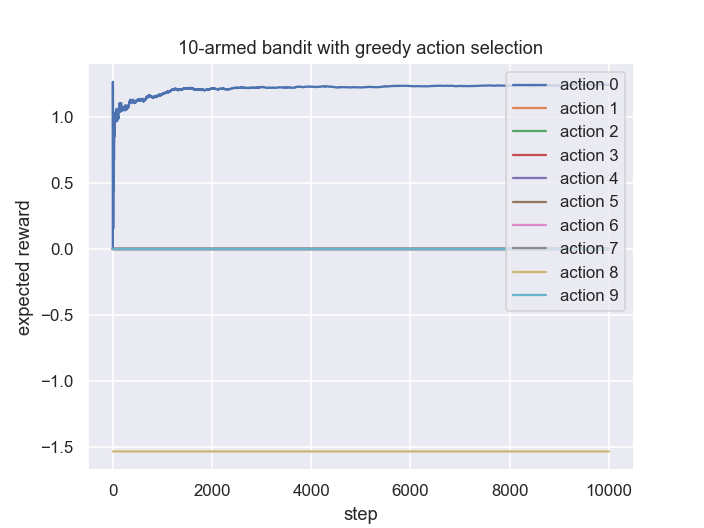

In [6]:
for idx in range(bandit.k):
    plt.plot(agent.expected_reward_log[:, idx], label=f'action {idx}')
plt.title('10-armed bandit with greedy action selection')
plt.ylabel('expected reward')
plt.xlabel('step')
plt.legend(loc='upper right')

<IPython.core.display.Javascript object>


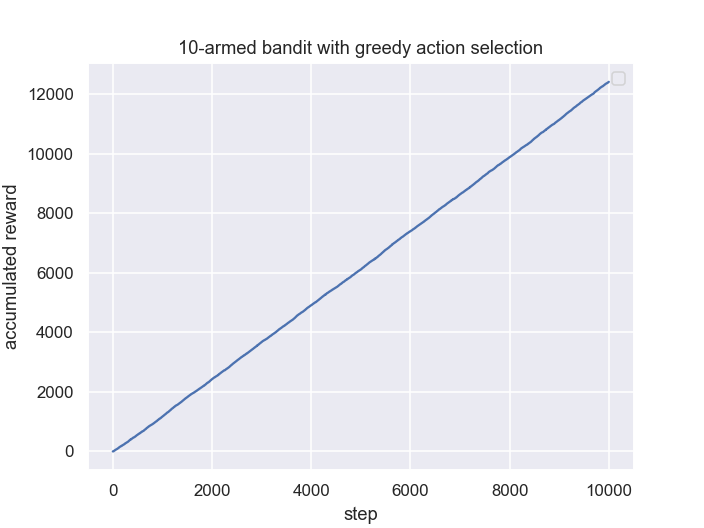

No handles with labels found to put in legend.


In [7]:
plt.plot(agent.accumulated_reward)
plt.title('10-armed bandit with greedy action selection')
plt.ylabel('accumulated reward')
plt.xlabel('step')
plt.legend(loc='upper right')

Actual expected reward values

In [8]:
bandit.q_a

array([ 1.23714   , -0.78123522, -0.74346399,  0.63246067,  0.74617241,
        2.2264248 , -0.19144806,  0.33097583, -0.4209462 , -0.53979833])

In [9]:
agent = GreedyAgent(bandit, epsilon=0.1)

In [10]:
for i in range(10000):
    agent.perform_action()

Evolution of expected reward values with $\epsilon=0.1$

<IPython.core.display.Javascript object>


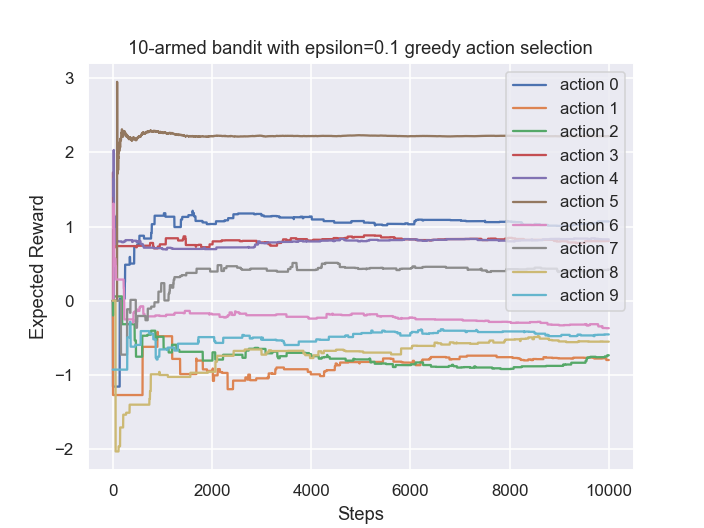

In [11]:
for idx in range(bandit.k):
    plt.plot(agent.expected_reward_log[:, idx], label=f'action {idx}')
plt.title('10-armed bandit with epsilon=0.1 greedy action selection')
plt.ylabel('Expected Reward')
plt.xlabel('Steps')
plt.legend(loc='upper right')

In [ ]:
plt.plot(agent.accumulated_reward)
plt.title('10-armed bandit with epsilon=0.1 greedy action selection')
plt.ylabel('accumulated reward')
plt.xlabel('step')
plt.legend(loc='upper right')

## Ensemble of bandits

Define an ensemble of 2000 bandit problems and investigate the average performance over a number of steps. This is the "10-armed testbed" decribed in chapter 2.

In [13]:
class Ensemble:
    """
    An ensemble of N k-armed bandit problems.
    
    Args:
        N: Number of bandits
        k: Number of actions
        epsilon: epsilon value for epsilon greedy action method
        log_expected_rewards: optionally log expected rewards
    
    Attributes:
        bandits: List of KArmedBandit instances
        agents: List of agents. Each agent is assigned to a bandit
        steps: number of steps performed
        average_rewards: List of average reward values over all agents at each step
        fraction_optimal_action: Fraction of agents performing optimal action at each
            step
    """
    
    def __init__(self, N=2000, k=10, epsilon=None, log_expected_rewards=False):
        self.N = N
        self.k = k
        self.epsilon = epsilon
        self.bandits = [KArmedBandit(k=k) for _ in range(N)]
        self.agents = [
            GreedyAgent(bandit=bandit, epsilon=epsilon, log_expected_rewards=False)
            for bandit in self.bandits
        ]
        self.steps = 0
        self.average_rewards = []
        self.fraction_optimal_actions = []
        
    def reinitialize_agents(self, epsilon=None):
        """
        Keep ensemble of bandits but reset steps and reinitialise agents
        """
        self.agents = [
            GreedyAgent(bandit=bandit, epsilon=epsilon, log_expected_rewards=False)
            for bandit in self.bandits
        ]
        self.steps = 0
        self.average_rewards = []
        self.fraction_optimal_actions = []
    
    def perform_actions(self, n_steps):
        """
        Perform action for n_steps, updating average rewards and optimal actions
        """
        for _ in range(n_steps):
            actions = []
            rewards = []
            for agent in self.agents:
                action, reward = agent.perform_action()
                rewards.append(reward)
                actions.append(action)
                # print(reward, action)
            
            fraction_optimal_action = np.sum([
                1 for agent, action in zip(self.agents, actions)
                if action == np.argmax(agent.bandit.q_a)
            ]) / self.N
            self.fraction_optimal_actions.append(fraction_optimal_action)
            self.average_rewards.append(np.mean(rewards))
            self.steps += 1
            if not self.steps % 100:
                print(f'steps: {self.steps}')

Create ensemble of bandits

In [14]:
ensemble = Ensemble()

Perform actions for greedy action method ($\epsilon=0.0$)

In [15]:
ensemble.perform_actions(2000)
average_rewards_greedy = ensemble.average_rewards
optimal_actions_greedy = ensemble.fraction_optimal_actions

steps: 100
steps: 200
steps: 300
steps: 400
steps: 500
steps: 600
steps: 700
steps: 800
steps: 900
steps: 1000
steps: 1100
steps: 1200
steps: 1300
steps: 1400
steps: 1500
steps: 1600
steps: 1700
steps: 1800
steps: 1900
steps: 2000


Reinitialise agents and perform actions for $\epsilon=0.1$

In [16]:
ensemble.reinitialize_agents(epsilon=0.1)
ensemble.perform_actions(2000)
average_rewards_01 = ensemble.average_rewards
optimal_actions_01 = ensemble.fraction_optimal_actions

steps: 100
steps: 200
steps: 300
steps: 400
steps: 500
steps: 600
steps: 700
steps: 800
steps: 900
steps: 1000
steps: 1100
steps: 1200
steps: 1300
steps: 1400
steps: 1500
steps: 1600
steps: 1700
steps: 1800
steps: 1900
steps: 2000


Reinitialise agents and perform actions for $\epsilon=0.01$

In [17]:
ensemble.reinitialize_agents(epsilon=0.01)
ensemble.perform_actions(2000)
average_rewards_001 = ensemble.average_rewards
optimal_actions_001 = ensemble.fraction_optimal_actions

steps: 100
steps: 200
steps: 300
steps: 400
steps: 500
steps: 600
steps: 700
steps: 800
steps: 900
steps: 1000
steps: 1100
steps: 1200
steps: 1300
steps: 1400
steps: 1500
steps: 1600
steps: 1700
steps: 1800
steps: 1900
steps: 2000


Plot average rewards for each action value method

<IPython.core.display.Javascript object>


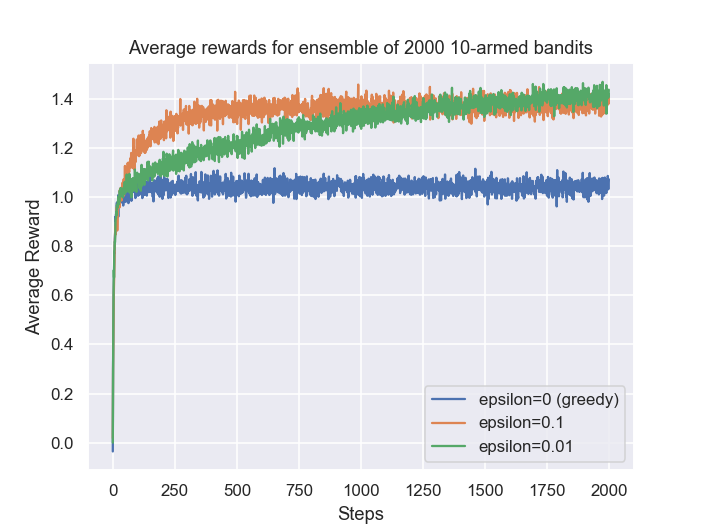

In [18]:
plt.plot(average_rewards_greedy, label='epsilon=0 (greedy)')
plt.plot(average_rewards_01, label='epsilon=0.1')
plt.plot(average_rewards_001, label='epsilon=0.01')
plt.title('Average rewards for ensemble of 2000 10-armed bandits')
plt.ylabel('Average Reward')
plt.xlabel('Steps')
plt.legend(loc='lower right')

In [19]:
max_average_reward = np.mean([np.max(bandit.q_a) for bandit in ensemble.bandits])

print(f'Highest possible average reward = {max_average_reward}')

Highest possible average reward = 1.5381638379306806


The above figure shows that the average reward value of the greedy method plateaus around 1.0. The methods with non-zero $\epsilon$ values are able to achieve a higher average reward, with the maximum average reward being 1.54. The lower value of $\epsilon=0.01$ is able to achieve a greater average reward because it samples the optimal action more often than the $\epsilon=0.1$ method. 

<IPython.core.display.Javascript object>


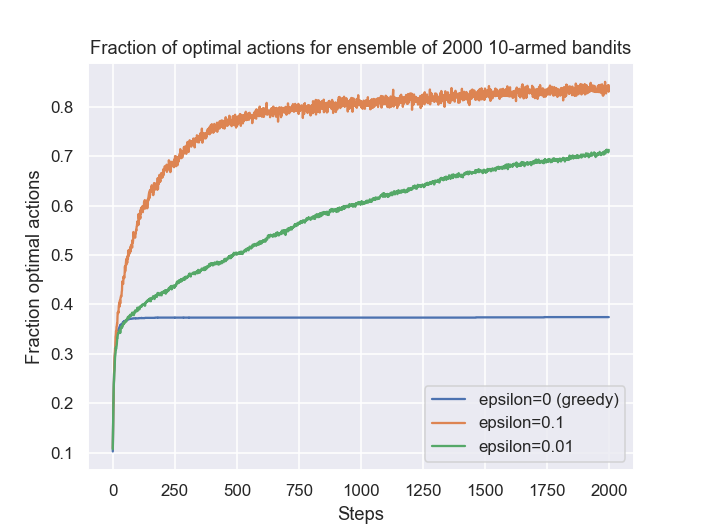

In [20]:
plt.plot(optimal_actions_greedy, label='epsilon=0 (greedy)')
plt.plot(optimal_actions_01, label='epsilon=0.1')
plt.plot(optimal_actions_001, label='epsilon=0.01')
plt.title('Fraction of optimal actions for ensemble of 2000 10-armed bandits')
plt.ylabel('Fraction optimal actions')
plt.xlabel('Steps')
plt.legend(loc='lower right')